# Visión Tarea 9 
### Hacer la implementación para calcular la convolución utilizando Imágenes integrales.
#### Daniel Castro Pineda

In [129]:
import numpy as np
from time import perf_counter
import cv2
import numba as nb

## a) Escribir una función que permita calcular la imagen integral. La función se llamará Integral y recibirá como paramentos una imagen I y regresará una imagen integral H. 

In [130]:
# @nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def integralImg(img):
    nr = img.shape[0]
    nc = img.shape[1]
    intImg = np.zeros((nr, nc))
    for r in range(nr):
        for c in range(nc):
            intImg[r, c] = img[r, c]
            if r > 0:
                intImg[r, c] += intImg[r-1, c]
            if c > 0:
                intImg[r, c] += intImg[r, c-1]
            if r > 0 and c > 0:
                intImg[r, c] -= intImg[r-1, c-1]
    return intImg


In [131]:
x = np.ones((5, 7), dtype=np.uint8)

In [132]:
ticks = perf_counter()
intImg = integralImg(x)
ticks = perf_counter() - ticks
print("Time: ", ticks)
print("Imagen integral")
print(intImg)

print("Imagen integral utilizando OpenCV")
cvIntImg = cv2.integral(x)
cvIntImg = cvIntImg[1:, 1:]
print(cvIntImg)


Time:  0.09176458300134982
Imagen integral
[[ 1.  2.  3.  4.  5.  6.  7.]
 [ 2.  4.  6.  8. 10. 12. 14.]
 [ 3.  6.  9. 12. 15. 18. 21.]
 [ 4.  8. 12. 16. 20. 24. 28.]
 [ 5. 10. 15. 20. 25. 30. 35.]]
Imagen integral utilizando OpenCV
[[ 1  2  3  4  5  6  7]
 [ 2  4  6  8 10 12 14]
 [ 3  6  9 12 15 18 21]
 [ 4  8 12 16 20 24 28]
 [ 5 10 15 20 25 30 35]]


## b) Escribir una función que realice la implementación de una función llamada Caja que recibirá como parámetros la imagen integral H, el renglón r y columna c, así como el numero de renglones N y de columnas M de la caja con N = 2n+1 y M=2m+1,

In [133]:

def caja(intImg, r, c, n, m):
    N = 2*n+1
    M = 2*m+1
    pad = (N - 1) // 2

    nrows, ncols = intImg.shape

    r0 = r - pad
    c0 = c - pad
    r1 = r + pad
    c1 = c + pad

    if r1 >= nrows:
        r1 = nrows - 1
    if c1 >= ncols:
        c1 = ncols - 1

    s0 = intImg[r1, c1]
    s1 = 0
    s2 = 0
    s3 = 0

    if r0 > 0:
        s1 = intImg[r0-1, c1]
    if c0 > 0:
        s2 = intImg[r1, c0-1]
    if r0 > 0 and c0 > 0:
        s3 = intImg[r0-1, c0-1]
    out = s0 - s1 - s2 + s3
    return out


def cajaCompleta(img, n, m):

    N = 2*n+1
    M = 2*m+1

    kernelx = np.ones((N))
    kernely = np.ones((M))

    # print(kernelx)
    # print(kernely)

    nrows, ncols = img.shape
    k_size = kernelx.size
    # krows, kcols = kernel.shape
    pad_size = (k_size - 1) // 2
    padded_img = np.pad(img, pad_size, mode='constant')
    # print(padded_img)
    output = np.zeros((nrows, ncols))

    for i in range(nrows):
        # print(img[i,:], i )
        output[i, :] = convolveDot(img[i, :], kernelx)
    # print(output)
    output2 = np.zeros((nrows, ncols))

    for j in range(ncols):
        output2[:, j] = convolveDot(output[:, j], kernely)
        # print(img[:, j])
    # print(output2)
    return output2


def convolveDot(signal, kernel):
    ker_size = kernel.size
    sig_size = signal.size
    # kernel = kernel[::-1]
    pad_size = (ker_size - 1) // 2
    padded_signal = np.pad(signal, pad_size, mode='constant')
    output = np.zeros(sig_size)
    output = [np.dot(padded_signal[k:k+ker_size], kernel)
              for k in range(sig_size)]
    return output


Probamos con una caja de 3x3 (n=1, m=1) para las localidades : 

$$\ I[1,1] = 4$$

$$\ I[2,3] = 9$$


In [134]:
print(caja(intImg, 0, 0, 1, 1))
print(caja(intImg, 2, 3, 1, 1))

4.0
9.0


Ahora se realiza la operación de caja para la imagen completa.

In [135]:
print(cajaCompleta(x, 1, 1))


[[4. 6. 6. 6. 6. 6. 4.]
 [6. 9. 9. 9. 9. 9. 6.]
 [6. 9. 9. 9. 9. 9. 6.]
 [6. 9. 9. 9. 9. 9. 6.]
 [4. 6. 6. 6. 6. 6. 4.]]


## d) Escribir una función SuavizadoIntegral que recibirá como parámetros la imagen I y el tamaño de la caja,

In [136]:
@nb.jit(nopython=True)
def SuavizadoIntegral(img, boxSize):
    imgIntegral = integralImg(img)
    N = 2*boxSize+1
    nrows, ncols = imgIntegral.shape
    pad = (N - 1) // 2
    integralSuavizada = np.zeros((nrows, ncols))

    for r in range(nrows):
        for c in range(ncols):
            r0 = r - pad
            c0 = c - pad
            r1 = r + pad
            c1 = c + pad

            if r1 >= nrows:
                r1 = nrows - 1
            if c1 >= ncols:
                c1 = ncols - 1

            s0 = imgIntegral[r1, c1]
            s1 = 0
            s2 = 0
            s3 = 0

            if r0 > 0:
                s1 = imgIntegral[r0-1, c1]
            if c0 > 0:
                s2 = imgIntegral[r1, c0-1]
            if r0 > 0 and c0 > 0:
                s3 = imgIntegral[r0-1, c0-1]
            integralSuavizada[r, c] = s0 - s1 - s2 + s3
    return integralSuavizada


In [137]:
ticks = perf_counter()
a = SuavizadoIntegral(x, 1)
ticks = perf_counter() - ticks
print("Time: ", ticks)
print(a)



Time:  0.12032520799766644
[[4. 6. 6. 6. 6. 6. 4.]
 [6. 9. 9. 9. 9. 9. 6.]
 [6. 9. 9. 9. 9. 9. 6.]
 [6. 9. 9. 9. 9. 9. 6.]
 [4. 6. 6. 6. 6. 6. 4.]]


## d) Mostrar que la función del inciso c y el suavizador de caja dan el mismo resultado de forma numérica

Para la siguiente imagen:
<table>
    <tr>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
    </tr>
    <tr>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
    </tr>
    <tr>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
    </tr>
    <tr>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
    </tr>
    <tr>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
    </tr>
</table>


La salida esperada es:

<table>
    <tr>
        <td>4</td>
        <td>6</td>
        <td>6</td>
        <td>6</td>
        <td>6</td>
        <td>6</td>
        <td>4</td>
    </tr>
    <tr>
        <td>6</td>
        <td>9</td>
        <td>9</td>
        <td>9</td>
        <td>9</td>
        <td>9</td>
        <td>6</td>
    </tr>
    <tr>
        <td>6</td>
        <td>9</td>
        <td>9</td>
        <td>9</td>
        <td>9</td>
        <td>9</td>
        <td>6</td>
    </tr>
    <tr>
        <td>6</td>
        <td>9</td>
        <td>9</td>
        <td>9</td>
        <td>9</td>
        <td>9</td>
        <td>6</td>
    </tr>
    <tr>
        <td>4</td>
        <td>9</td>
        <td>9</td>
        <td>9</td>
        <td>9</td>
        <td>9</td>
        <td>4</td>
    </tr>
</table>

In [138]:
print("Caja completa: ")
print(cajaCompleta(x, 1, 1))

print("Suavizado Integral: ")
print(SuavizadoIntegral(x, 1))


Caja completa: 
[[4. 6. 6. 6. 6. 6. 4.]
 [6. 9. 9. 9. 9. 9. 6.]
 [6. 9. 9. 9. 9. 9. 6.]
 [6. 9. 9. 9. 9. 9. 6.]
 [4. 6. 6. 6. 6. 6. 4.]]
Suavizado Integral: 
[[4. 6. 6. 6. 6. 6. 4.]
 [6. 9. 9. 9. 9. 9. 6.]
 [6. 9. 9. 9. 9. 9. 6.]
 [6. 9. 9. 9. 9. 9. 6.]
 [4. 6. 6. 6. 6. 6. 4.]]


##  e) Hacer una gráfica que muestre el tiempo que tarda la convolución con imágenes integrales y la convolución desacoplada para el kernel de caja. Los cálculos se harán para valores N=M y N=3, 5, 7, 9, …. 41.


In [139]:
x = np.ones((1024,1024))

In [140]:
tamkernel = [i for i in range(1, 21)]
tiempoSI = []
for i in tamkernel:
    ticks = perf_counter()
    a = SuavizadoIntegral(x, i)
    # print(a)
    ticks = perf_counter() - ticks
    tiempoSI.append(ticks)
    # print(i*2+1)

print(tiempoSI, tamkernel)

[0.2763461249996908, 0.006305416001850972, 0.0063497499977529515, 0.006314750000456115, 0.006258834000618663, 0.006433708000258775, 0.006302665999101009, 0.0062989170000946615, 0.006231499999557855, 0.006376624998665648, 0.006376875000569271, 0.0063496660004602745, 0.00626462500076741, 0.006332749999273801, 0.006468540999776451, 0.006315792001259979, 0.00629658300022129, 0.006300375000137137, 0.0062373750006372575, 0.006383207997714635] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [141]:
tiempoCC = []
for i in tamkernel:
    ticks = perf_counter()
    a = cajaCompleta(x, i, i)
    # print(a)
    ticks = perf_counter() - ticks
    tiempoCC.append(ticks)

print(tiempoCC, tamkernel)

[1.765367416999652, 1.7774745829992753, 1.7661429159998079, 1.7497821249999106, 1.7358264579997922, 1.7679916249981034, 1.7706894170005398, 1.739510583000083, 1.7743779580014234, 1.7996566660003737, 1.7790877499974158, 1.7794221670010302, 1.792778166000062, 1.770890583000437, 1.8103138750011567, 1.7837477080029203, 1.7701506250014063, 1.7840293749977718, 1.7814587499997288, 1.7966676670002926] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


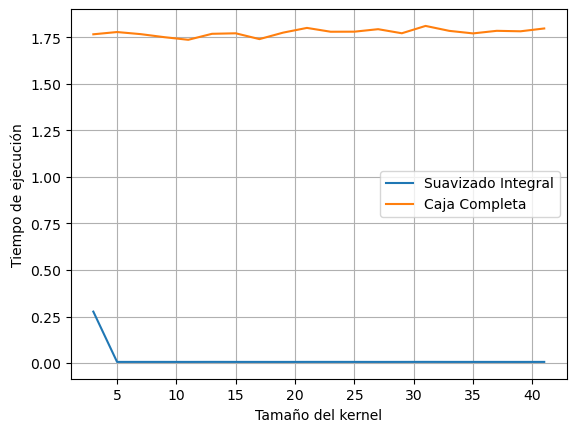

In [142]:
import matplotlib.pyplot as plt

N = [i*2+1 for i in tamkernel]



plt.plot(N, tiempoSI, label="Suavizado Integral")
plt.plot(N, tiempoCC, label="Caja Completa")

plt.xlabel("Tamaño del kernel")
plt.ylabel("Tiempo de ejecución")

plt.legend()
plt.grid()
plt.show()

[0.2763461249996908, 0.2826515410015418, 0.2890012909992947, 0.29531604099975084, 0.3015748750003695, 0.3080085830006283, 0.3143112489997293, 0.32061016599982395, 0.3268416659993818, 0.33321829099804745, 0.3395951659986167, 0.345944831999077, 0.3522094569998444, 0.3585422069991182, 0.36501074799889466, 0.37132654000015464, 0.3776231230003759, 0.38392349800051306, 0.3901608730011503, 0.39654408099886496] [1.765367416999652, 3.5428419999989273, 5.308984915998735, 7.058767040998646, 8.794593498998438, 10.562585123996541, 12.333274540997081, 14.072785123997164, 15.847163081998588, 17.64681974799896, 19.425907497996377, 21.205329664997407, 22.99810783099747, 24.768998413997906, 26.579312288999063, 28.363059997001983, 30.13321062200339, 31.91723999700116, 33.69869874700089, 35.49536641400118]


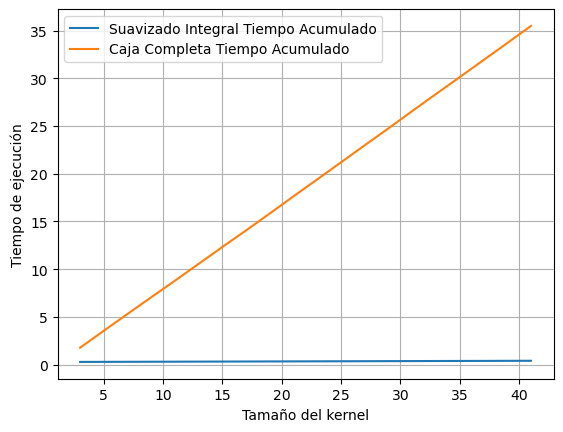

In [145]:
AcumuladoSI = []
AcumuladoCC = []

for i in range(len(tiempoSI)):
    AcumuladoSI.append(sum(tiempoSI[:i+1]))
    AcumuladoCC.append(sum(tiempoCC[:i+1]))
print(AcumuladoSI, AcumuladoCC)

plt.plot(N, AcumuladoSI, label="Suavizado Integral Tiempo Acumulado")
plt.plot(N, AcumuladoCC, label="Caja Completa Tiempo Acumulado")
plt.xlabel("Tamaño del kernel")
plt.ylabel("Tiempo de ejecución")
plt.legend()
plt.grid()

Se puede observar que la convolución con imágenes integrales es más rápida que la convolución desacoplada. Siendo más notoria la diferencia entre más grande es la caja. Además se es aun más notoria al acumular los tiempos de ejecución. 